# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
# !pip install anndata lightgbm

In [2]:
# !conda install -c conda-forge graph-tool -y 

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import tqdm
import scipy
import json
from regression import format_folder

os.environ['KMP_DUPLICATE_LIB_OK']='True'

work_dir = '../output'
resource_dir = '../resources'
os.makedirs(f'{work_dir}', exist_ok=True)

In [2]:
methods = ['Random',
 'CollectRI',
 'FigR',
 'CellOracle',
 'GRaNIE',
 'ANANSE',
 'scGLUE',
 'Scenic+',
 'HKG',
 'Positive',
 'Negative',
 'Positive Control',
 'Negative Control']


# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRaNIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRANIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKGs': 'darkblue',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}
# LINESTYLES = {
#     'Random': '-',
#     'CollectRI': '--',
#     'FigR': '-.',
#     'CellOracle': ':',
#     'GRaNIE': ':',
#     'ANANSE': '--',
#     'scGLUE': '-.',
#     'Scenic+': '-',
# }

surragate_names = {
    'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
    'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
    'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
    'FigR': 'FigR', 'figr':'FigR', 'figr_sign':'FigR-signs',
    'baseline':'Baseline',
    'cov_net': 'Pearson cov',
    'GRANIE': 'GRANIE', 'granie':'GRANIE',
    'ANANSE': 'ANANSE', 'ananse':'ANANSE',
    'scGLUE': 'scGLUE', 'scglue':'scGLUE',
    'HKG': 'HKG', 'HKGs':'HKG',
    'positive-control': 'Positive Control', 'positive_control': 'Positive Control',
    'negative-control': 'Negative Control', 'negative_control':'Negative Control',
    'pearson':'APR',
    'lognorm': 'SLA',
    'SL':'SLA',
    'scgen_pearson':'scGEN-APR', 'scgen_lognorm':'scGEN-SLA', 'seurat_pearson':'Seurat-APR', 'seurat_lognorm':'Seurat-SLA',
}

# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRANIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRANIE': '-',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': ':',
    'Positive Control': '-',
    'Negative Control': '-'
}

MARKERS = {
    'Random': '.',
    'CollectRI': '.',
    'FigR': 'o',
    'CellOracle': 'd',
    'GRANIE': 'v',
    'ANANSE': 's',
    'scGLUE': 'x',
    'Scenic+': '*',
    'Positive Control': '.',
    'Negative Control': '.'
}

In [ ]:
# ## Formatize filing 
# def format_folder_old(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample=None):
#     return f'{work_dir}/benchmark/_scores/subsample_{subsample}/exclude_missing_genes_{exclude_missing_genes}/{reg_type}/theta_{theta}_tf_n_{tf_n}/{norm_method}'


# def format_file(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample=None, manipulate=None):
#     folder = f'{work_dir}/benchmark/scores/{grn_model}/{exclude_missing_genes}_{tf_n}_{subsample}_{}
#     return 
    
#     subsample_{subsample}/exclude_missing_genes_{exclude_missing_genes}/{reg_type}/theta_{theta}_tf_n_{tf_n}/{norm_method}'



# for grn_model in grn_models:
#     for exclude_missing_genes in [True, False]:
#         for tf_n in [140, None]:
#             for subsample in [200, None]:
#                 for norm_method in datasets:
#                     for theta in np.linspace(0, 1, 5):
#                         for reg_type in ['ridge','GB']:
#                             file = f'{format_folder_old(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{grn_model}_{manipulate}.json'
#                             if not os.path.exists(file):
#                                 print(f'Missing file: {file}')
#                             else:
#                                 if tf_n is None:
#                                     tf_n = -1
#                                 if subsample is None:
#                                     subsample = -1
#                                 if exclude_missing_genes:
#                                     exclude_missing_genes = 
#                                 else:
#                                     exclude_missing_genes = -1
#                                 # with open(file, 'r') as f:
#                                 #     data = json.load(f)
#                                 pass 


# # file = f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{grn_model}_{manipulate}.json'


In [3]:
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


In [318]:
grn_model_names = ['figr', 'celloracle', 'granie', 'scglue', 'scenicplus']

n_nets = len(grn_model_names)


grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [322]:
tfs_n_list = [grn.source.unique().shape[0] for grn in grn_models_dict.values()]
print(np.min(tfs_n_list), np.median(tfs_n_list), np.max(tfs_n_list))

140 389.0 557


# main analysis

In [12]:
datasets = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm'] # ['seurat_lognorm', 'scgen_pearson']
grn_models = ['negative_control', 'collectRI', 'granie', 'celloracle', 'figr', 'scglue', 'scenicplus', 'positive_control']


def extract_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets, grn_models):
    mat = []
    for i_plot, norm_method in enumerate(datasets):
        row = []
        for grn_model in grn_models:
            file = f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{grn_model}_{manipulate}.json'
            if not os.path.exists(file):
                print(f'Missing file: {file}')
                mean_score = np.nan
            else:
                with open(file, 'r') as f:
                    data = json.load(f)
                mean_score = data['mean_score_r2']
            row.append(mean_score)
        mat.append(row)
    mat = np.asarray(mat)
    mat_df = pd.DataFrame(mat, index=[surragate_names[label] for label in datasets], columns=[surragate_names[label] for label in grn_models])

    mat_df.loc['Mean'] = mat_df.mean(axis=0)
    return mat_df 

## Experiment with thetas

In [478]:
experiment='theta'
reg_type = 'ridge'
subsample = 200
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --force

experiment='theta',exclude_missing_genes=False,force=True, manipulate=None, subsample=200
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 1) (15215, 200)
score_r2:  -0.0002470153941340374 loss_mse:  0.16152546
../output/benchmark/scores/subsample_200/exclude_missing_genes_False/ridge/theta_0.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='ridge', norm_method='seurat_lognorm', model_name='negative_control', exclude_missing_genes=False
(15215, 1) (15215, 200)
score_r2:  -0.00033329915044576154 loss_mse:  0.9147851111479717
../output/benchmark/scores/subsample_200/exclude_missing_genes_False/ridge/theta_0.0_tf_n_None/seurat_lognorm/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 104) (15215, 200)
score_r2:  -0.009348281161249439 loss_mse:  0.16299516
../output/benchmark/scores/subsample_200/exclude_missing_genes_False

In [440]:
experiment='theta'
reg_type = 'GB'
subsample = 200
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample}

experiment='theta',exclude_missing_genes=False,force=False, manipulate=None, subsample=200
reg_type='GB', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='GB', norm_method='seurat_lognorm', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.0_tf_n_None/seurat_lognorm/negative_control_None.json
reg_type='GB', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.25_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='GB', norm_method='seurat_lognorm', model_name='negative_control', exclude_missing_g

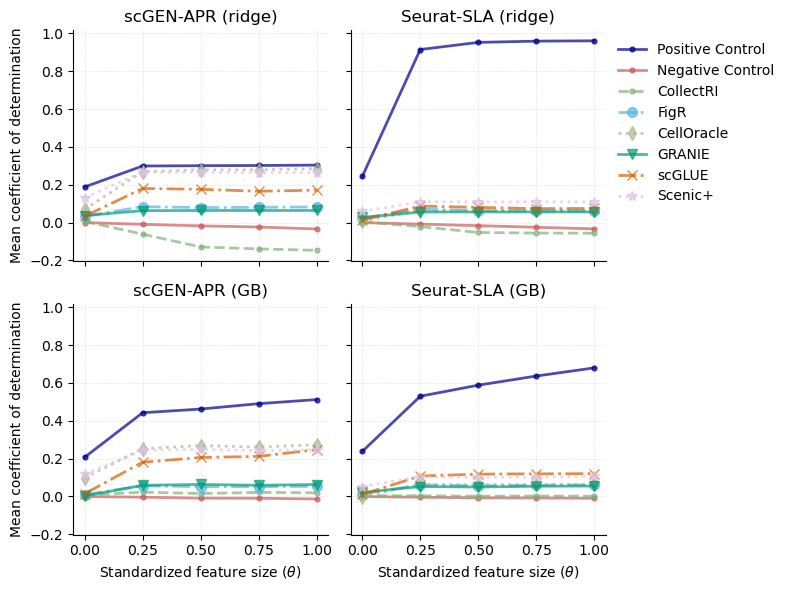

In [710]:
subsample = 200

manipulate = None
exclude_missing_genes = False
tf_n = None

SORTED_METHODS = ['positive_control', 'negative_control', 'collectRI', 'figr', 'celloracle', 'granie', 'scglue', 'scenicplus']
NORM_METHODS = ['scgen_pearson',  'seurat_lognorm']

def line_plot_theta(reg_type, axes):
    
        
    markersize = 7
    linewidth = 2
    for k, norm_method,  in enumerate(NORM_METHODS):

        ax =axes[k]
        ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')
        xs = np.linspace(0, 1, 5)
        for method in SORTED_METHODS:

            series = []
            for theta in np.linspace(0, 1, 5):
                file =  f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{method}_{manipulate}.json'
                if not os.path.exists(file):
                    print(f'Missing file: {file}')
                    mean_score = np.nan
                else:
                    with open(file, 'r') as f:
                        data = json.load(f)
                    mean_score = data['mean_score_r2']

                series.append(float(mean_score))
            
            ax.plot(
                xs, series, label=surragate_names[method], color=COLORS[surragate_names[method]], markersize=markersize,
                linestyle=LINESTYLES[surragate_names[method]], marker=MARKERS[surragate_names[method]], alpha=0.7, linewidth=linewidth
            )

        ax.set_xticks(xs)
        ax.set_title(f'{surragate_names[norm_method]} ({reg_type})')
        if k == 0:
            ax.set_ylabel('Mean coefficient of determination')
        
            
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        if reg_type=='GB':
            ax.set_xlabel(r'Standardized feature size ($\theta$)')
        else:
            if k == 1:
                ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)


fig, axes = plt.subplots(2, len(NORM_METHODS), figsize=(4*len(NORM_METHODS), 6), sharey=True, sharex=True)

line_plot_theta('ridge', axes[0])
line_plot_theta('GB', axes[1])
plt.tight_layout()
plt.savefig(f'{work_dir}/benchmark/figs/first-validation-performance-theta.png', dpi=300, transparent=True)
plt.show()

## Subsample
run for all datasets for a subsample of 200 from 2100 samples


In [20]:
experiment = 'default'
reg_type = 'ridge'
subsample=200 
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --force
# !python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --exclude-missing-genes --force

experiment='default',exclude_missing_genes=False,force=True, manipulate=None, subsample=200
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.033600852480656945 loss_mse:  0.19718029310314533
{'mean_score_r2': -0.033600852480656945, 'gene_scores_r2': [-0.8944613359755129, -0.2025664284460693, -0.026973275109317685, 0.025492714678525763, 0.069874425684198, -0.8515106559772345, -0.00359539957989341, -0.7228286134275275, -0.17092464474200808, -0.31586134539073196, -0.1460228918042319, 0.138849039724375, -0.010403657271844002, -0.3286210218675678, -3.435087980800448, -0.3052837159238089, -0.19054414190133007, -0.15621782837686715, -0.38266844389507293, 0.007703997652153904, -0.052784697673841974, -0.35621709340565233, -0.4344229783223885, -0.9648651637321728, -0.3471623289596293, -0.5417568341272128, -0.27406251392670833, -0.4000730358003173, -0.7257192472291993, -0.1586536938359311, -0.57208668909659

In [482]:
experiment = 'default'
reg_type = 'GB'
subsample=200 
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} 
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --exclude-missing-genes

experiment='default',exclude_missing_genes=False,force=False, manipulate=None, subsample=200
reg_type='GB', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_1.0_tf_n_None/pearson/negative_control_None.json
reg_type='GB', norm_method='pearson', model_name='positive_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_1.0_tf_n_None/pearson/positive_control_None.json
reg_type='GB', norm_method='pearson', model_name='collectRI', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_1.0_tf_n_None/pearson/collectRI_None.json
reg_type='GB', norm_method='pearson', model_name='figr', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scor

### plot heatmap

Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/negative_control_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/collectRI_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/granie_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/celloracle_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/figr_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/scglue_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/scenicplus_None.json
Missing file: .

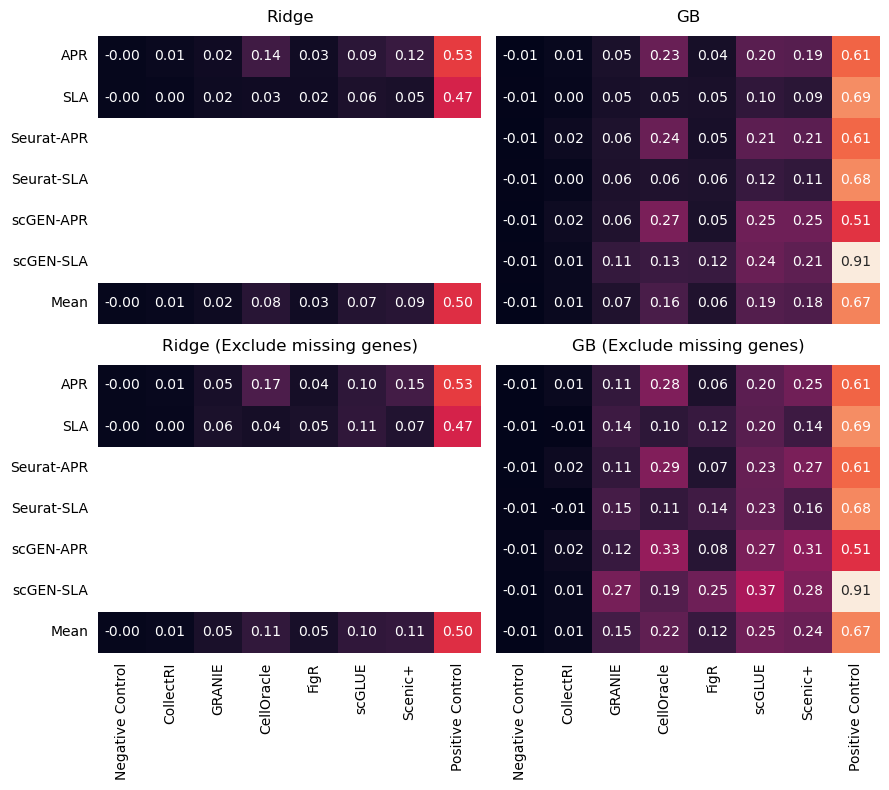

In [34]:

manipulate=None
subsample=200
theta = 1.0
tf_n = None

fig, axes = plt.subplots(2, 2, figsize=(9, 8), sharey=True, sharex=True)
for j, exclude_missing_genes in enumerate([False, True]):
    mat_ridge = extract_table('rf', exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets=datasets, grn_models=grn_models)
    mat_gb = extract_table('GB', exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets=datasets, grn_models=grn_models)


    # Combine both correlation matrices to find global min and max
    combined_mat = np.concatenate((mat_ridge.values.flatten(), mat_gb.values.flatten()))
    vmin = np.nanmin(combined_mat)
    vmax = np.nanmax(combined_mat)

    for i, (name, mat_df) in enumerate(zip(['Ridge', 'GB'], [mat_ridge, mat_gb])):
        ax = axes[j][i]
        seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)
        # Remove only the ticks, keep labels
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_tick_params(width=0)
        ax.yaxis.set_tick_params(width=0)
        if exclude_missing_genes:
            ax.set_title(f'{name} (Exclude missing genes)', pad=10)
        else:
            ax.set_title(f'{name}', pad=10)

    plt.tight_layout()

# plt.savefig(f'{work_dir}/benchmark/figs/first-validation-heatmap-subset.png', dpi=300, transparent=True,  bbox_inches='tight')

### variation across datasets

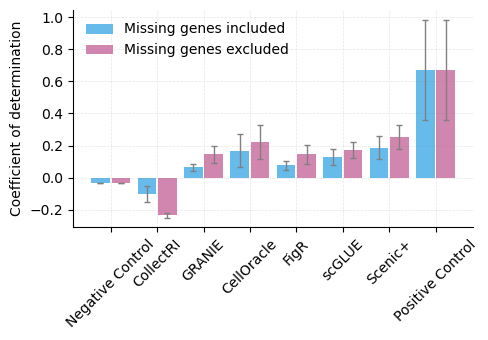

In [95]:
datasets = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm'] # ['seurat_lognorm', 'scgen_pearson']
reg_type = 'ridge'

mat_GB =  extract_table(reg_type, exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=200, datasets=datasets, grn_models=grn_models)
mat_GB_exc =  extract_table(reg_type, exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=200, datasets=datasets, grn_models=grn_models)

means_GB = mat_GB.loc['Mean']
stds_GB = mat_GB.drop('Mean').std(axis=0)

means_GB_exc = mat_GB_exc.loc['Mean']
stds_GB_exc = mat_GB_exc.drop('Mean').std(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(5, 3.5))

# Number of columns
n_cols = len(means_GB.index)

# X-axis positions
x = np.arange(n_cols)

# Width of the bars
width = 0.4
alpha = 0.9
colors = ['#56B4E9',  # Sky Blue
          '#CC79A7'] 
error_kw = dict(elinewidth=1, capsize=2, capthick=1, ecolor='grey')


bars1 = ax.bar(x - width/2-.02, means_GB, width, yerr=stds_GB,  label='Missing genes included', color=colors[0], alpha=alpha, error_kw=error_kw)
bars2 = ax.bar(x + width/2+.02, means_GB_exc, width, yerr=stds_GB_exc, label='Missing genes excluded', color=colors[1], alpha=alpha, error_kw=error_kw)

ax.set_ylabel('Coefficient of determination')
ax.set_xticks(x)
ax.set_xticklabels(means_GB.index, rotation=45)
ax.legend(frameon=False)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')

plt.tight_layout()

plt.savefig(f'{work_dir}/benchmark/figs/first-validation-variations-{reg_type}.png', dpi=300, transparent=True,  bbox_inches='tight')
# plt.show()


### Correlation between regression types

In [640]:
# lets find c
import scipy
scipy.stats.pearsonr(mat_gb.values.flatten(), mat_ridge.values.flatten())

PearsonRResult(statistic=0.9409050916630038, pvalue=4.646815272320079e-27)

### correlation between datasets 

In [679]:
mat_ridge =  extract_table('ridge', exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample)
mat_ridge_exc =  extract_table('ridge', exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample)
mat_GB =  extract_table('GB', exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample)
mat_GB_exc =  extract_table('GB', exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample)

mat_ridge = pd.concat([mat_ridge,mat_ridge_exc], axis=1).drop('Mean')
mat_gb = pd.concat([mat_GB, mat_GB_exc], axis=1).drop('Mean')

In [678]:
mat_GB.index

Index(['APR', 'SLA', 'Seurat-APR', 'Seurat-SLA', 'scGEN-APR', 'scGEN-SLA'], dtype='object')

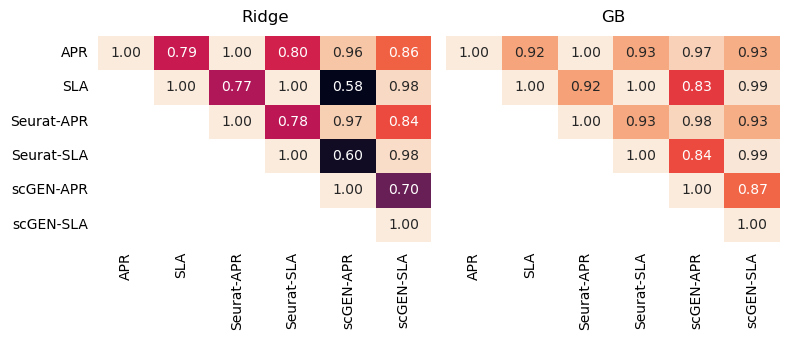

In [681]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
# Calculate the minimum and maximum correlation values across both datasets
df_corr_ridge = mat_ridge.T.corr().round(3)
df_corr_gb = mat_gb.T.corr().round(3)

# Combine both correlation matrices to find global min and max
combined_corr = np.concatenate((df_corr_ridge.values.flatten(), df_corr_gb.values.flatten()))
vmin = np.nanmin(combined_corr)
vmax = np.nanmax(combined_corr)

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True, sharex=True)
for i, (name, mat_df) in enumerate(zip(['Ridge', 'GB'], [mat_ridge, mat_gb])):  
    ax = axes[i]
    df_corr = mat_df.T.corr().round(3)
    mask = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)

    # Apply the mask to set values below the diagonal to NaN
    df_corr.where(~mask, other=np.nan, inplace=True)
    ax.set_title(name, pad=10)

    sns.heatmap(df_corr, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)

    # Remove only the ticks, keep labels
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)

plt.tight_layout()
plt.savefig(f'{work_dir}/benchmark/figs/datasets-correlation.png', dpi=300, transparent=True,  bbox_inches='tight')

## Full sample

In [686]:
experiment = 'default'
reg_type = 'ridge'
!python regression.py --experiment {experiment} --reg_type {reg_type} --force
!python regression.py --experiment {experiment} --reg_type {reg_type} --exclude-missing-genes

reg_type = 'GB'
!python regression.py --experiment {experiment} --reg_type {reg_type} 
!python regression.py --experiment {experiment} --reg_type {reg_type} --exclude-missing-genes

experiment='default',exclude_missing_genes=False,force=True, manipulate=None, subsample=None
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 2170)
score_r2:  -0.033751769118423564 loss_mse:  0.17718242
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='positive_control', exclude_missing_genes=False
(15215, 1056) (15215, 2170)
score_r2:  0.3008037449724995 loss_mse:  0.11984045
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/positive_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='collectRI', exclude_missing_genes=False
(15215, 1178) (15215, 2170)
score_r2:  -0.15487881247502722 loss_mse:  0.19794318
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/th

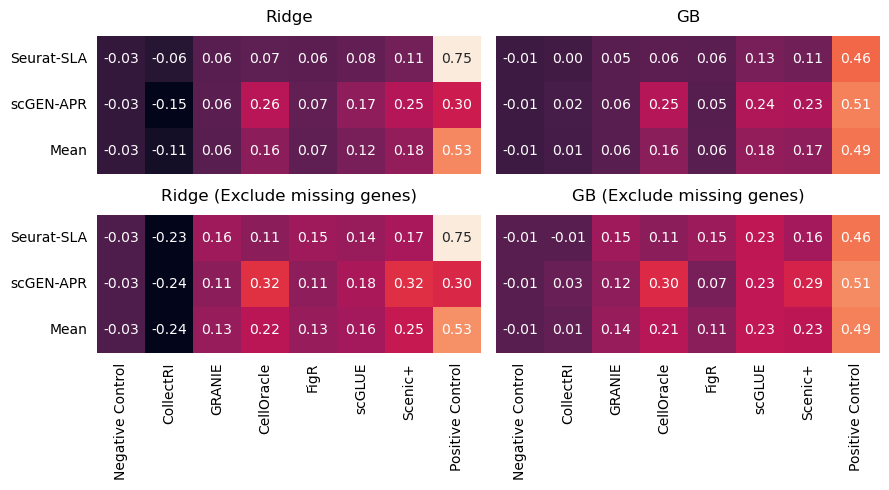

In [66]:
manipulate=None
subsample=None
theta = 1.0
tf_n = None


datasets = ['seurat_lognorm', 'scgen_pearson']
fig, axes = plt.subplots(2, 2, figsize=(9, 5), sharey=True, sharex=True)
for j, exclude_missing_genes in enumerate([False, True]):
    mat_ridge = extract_table('ridge', exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets, grn_models)
    mat_gb = extract_table('GB', exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets, grn_models)


    # Combine both correlation matrices to find global min and max
    combined_mat = np.concatenate((mat_ridge.values.flatten(), mat_gb.values.flatten()))
    vmin = np.nanmin(combined_mat)
    vmax = np.nanmax(combined_mat)

    for i, (name, mat_df) in enumerate(zip(['Ridge', 'GB'], [mat_ridge, mat_gb])):
        ax = axes[j][i]
        seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)
        # Remove only the ticks, keep labels
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_tick_params(width=0)
        ax.yaxis.set_tick_params(width=0)
        if exclude_missing_genes:
            ax.set_title(f'{name} (Exclude missing genes)', pad=10)
        else:
            ax.set_title(f'{name}', pad=10)

    plt.tight_layout()

plt.savefig(f'{work_dir}/benchmark/figs/first-validation-heatmap.png', dpi=300, transparent=True,  bbox_inches='tight')

### Correlation between subsample and full

In [701]:
import scipy.stats

for i, reg_type in enumerate(['ridge','GB']):
    mat =  extract_table(reg_type, exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=None).drop('Mean')
    mat_exc =  extract_table(reg_type, exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=None).drop('Mean')

    mat_sub =  extract_table(reg_type, exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=200).drop('Mean').loc[mat.index]
    mat_exc_sub =  extract_table(reg_type, exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=200).drop('Mean').loc[mat.index]

    mat = pd.concat([mat, mat_exc], axis=1)
    mat_sub = pd.concat([mat_sub, mat_exc_sub], axis=1)

    print(reg_type, scipy.stats.pearsonr(mat.values.flatten(), mat_sub.values.flatten()))

ridge PearsonRResult(statistic=0.9918495812983382, pvalue=2.087557029597194e-28)
GB PearsonRResult(statistic=0.9729588355840384, pvalue=1.19689469941413e-20)


### average across different tf-n

In [21]:
mat_df0 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=140, subsample=None, datasets=datasets, grn_models=grn_models)
mat_df1 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=None, subsample=None, datasets=datasets, grn_models=grn_models)

mat_df1-mat_df0

Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/seurat_lognorm/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/scgen_pearson/scenicplus_None.json


,Negative Control,CollectRI,GRANIE,CellOracle,FigR,scGLUE,Scenic+,Positive Control
Seurat-SLA,-0.004266,-0.002399,0.001348,-0.003633,-0.001329,0.009938,NaN,0.038940
scGEN-APR,-0.006528,0.000459,0.003482,0.014362,0.003623,0.033134,NaN,0.085304
Mean,-0.005397,-0.000970,0.002415,0.005365,0.001147,0.021536,NaN,0.062122


## Summarize scores 

In [67]:
mat_g1_df0 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=140, subsample=None, datasets=datasets, grn_models=grn_models)
mat_g1_df1 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=None, subsample=None, datasets=datasets, grn_models=grn_models)

mat_g1_df0['Scenic+'] = mat_g1_df1['Scenic+']

mat_g0_df0 = extract_table(reg_type='GB', exclude_missing_genes=True, manipulate=None, theta=1.0, tf_n=140, subsample=None, datasets=datasets, grn_models=grn_models)
mat_g0_df1 = extract_table(reg_type='GB', exclude_missing_genes=True, manipulate=None, theta=1.0, tf_n=None, subsample=None, datasets=datasets, grn_models=grn_models)

mat_g0_df0['Scenic+'] = mat_g0_df1['Scenic+']

Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/seurat_lognorm/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/scgen_pearson/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_140/seurat_lognorm/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_140/scgen_pearson/scenicplus_None.json


In [68]:
accuracy = (mat_g0_df0 + mat_g0_df1)/2
completeness = (mat_g1_df0 + mat_g1_df1)/2

summary = pd.DataFrame(columns=accuracy.columns)
summary.loc['Accuracy'] = accuracy.loc['Mean']
summary.loc['Comprehensiveness'] = completeness.loc['Mean']

summary

,Negative Control,CollectRI,GRANIE,CellOracle,FigR,scGLUE,Scenic+,Positive Control
Accuracy,-0.007917,0.010977,0.130268,0.206049,0.105221,0.224002,0.226161,0.458723
Comprehensiveness,-0.007405,0.009336,0.054727,0.154620,0.054929,0.170397,0.169230,0.458723


In [154]:
# regression 1 summary
metrics = ['g0_df0', 'g0_df1', 'g1_df0', 'g1_df1']
scores = [df.loc['Mean'].values for df in [mat_g0_df0, mat_g0_df1, mat_g1_df0, mat_g1_df1]]
models = mat_g0_df0.columns.values

reg1_summary = pd.DataFrame(scores, index=metrics, columns=models)
reg1_summary

,Negative Control,CollectRI,GRANIE,CellOracle,FigR,scGLUE,Scenic+,Positive Control
g0_df0,-0.005213,0.011551,0.124610,0.204106,0.104239,0.217091,0.226161,0.427649
g0_df1,-0.010620,0.010402,0.135925,0.207991,0.106202,0.230913,0.226161,0.489797
g1_df0,-0.004707,0.009821,0.053520,0.151938,0.054355,0.159629,0.169230,0.427661
g1_df1,-0.010104,0.008850,0.055935,0.157303,0.055502,0.181165,0.169230,0.489784


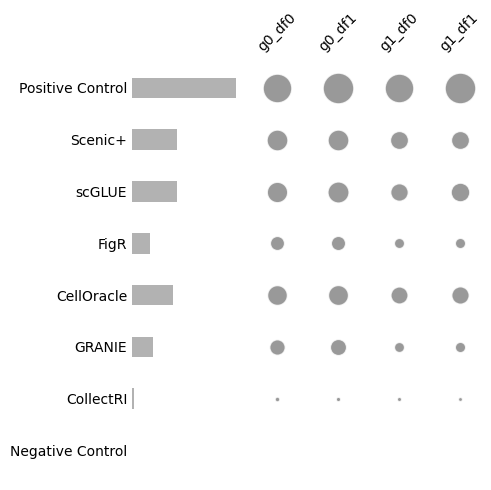

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
scale_size = 1000
alpha = .8
edgecolors='w'
fig, axes = plt.subplots(1, 2, figsize=(5, 5), gridspec_kw={'width_ratios': [1, 2]},sharey=True)

# Plot bars 
ax = axes[0]
bars = ax.barh(reg1_summary.columns, reg1_summary.mean(axis=0), color='grey', alpha=0.6, height=0.4)
ax.set_xticks([])
ax.tick_params(length=0)
for side in ['right', 'top', 'left', 'bottom']:
    ax.spines[side].set_visible(False)



# dots 
ax = axes[1]
reg1_summary = reg1_summary.where(reg1_summary>0, 0)
# print(reg1_summary)
xs = range(len(reg1_summary))
for i, (index, row) in enumerate(reg1_summary.iterrows()):
    for j in range(len(row.index)):
        ax.scatter(i, j, s=row.values[j]*scale_size,color='grey', alpha=alpha, edgecolors=edgecolors)
ax.set_xticks(range(len(reg1_summary)))
ax.set_xticklabels(reg1_summary.index, rotation=45, ha='center')
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
for side in ['right', 'top', 'left', 'bottom']:
    ax.spines[side].set_visible(False)
ax.set_xmargin(.1)
# ax.set_xlabel('Score')
# ax.set_title('Scores by Method')


# ax.set_yticks(range(len(df)))
# ax.set_yticklabels(df['Name'])

# Hide y-tick labels on the right plot
# ax.tick_params(axis='y', which='both', length=0)

plt.tight_layout()
plt.show()


,Negative Control,CollectRI,GRANIE,CellOracle,FigR,scGLUE,Scenic+,Positive Control
Accuracy,-0.007917,0.010977,0.130268,0.206049,0.105221,0.224002,0.226161,0.458723
Comprehensiveness,-0.007405,0.009336,0.054727,0.154620,0.054929,0.170397,0.169230,0.458723


## Signed 

In [9]:
# EXPERIMENT: default 
experiment = 'default'
reg_type = 'ridge'
manipulate = 'signed'
subsample=200 
# !python regression.py --experiment {experiment} --reg_type {reg_type} --manipulate {manipulate} --subsample {subsample} --force
!python regression.py --experiment {experiment} --reg_type {reg_type} --manipulate {manipulate} --subsample {subsample} --force --exclude-missing-genes

experiment='default',exclude_missing_genes=True,force=True, manipulate='signed', subsample=200
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=True
(15215, 400) (15215, 200)
score_r2:  -0.033600852480656945 loss_mse:  0.19718029310314533
../output/benchmark/scores/subsample_200/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/pearson/negative_control_signed.json
reg_type='ridge', norm_method='pearson', model_name='positive_control', exclude_missing_genes=True
(15215, 1056) (15215, 200)
score_r2:  0.38458070793318966 loss_mse:  0.11740369224718186
../output/benchmark/scores/subsample_200/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/pearson/positive_control_signed.json
reg_type='ridge', norm_method='pearson', model_name='collectRI', exclude_missing_genes=True
(4193, 1178) (4193, 200)
score_r2:  -0.24839661913699293 loss_mse:  0.5066693790047916
../output/benchmark/scores/subsample_200/exclude_missing_genes_True/ridge/theta_1.0_tf_

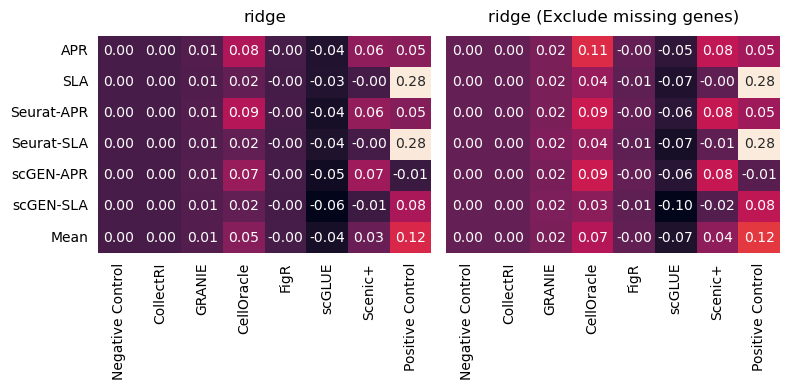

In [100]:
# manipulate='signed'
subsample=200
theta = 1.0
tf_n = None

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
for j, exclude_missing_genes in enumerate([False, True]):
    name = 'ridge'
    mat_df_signed = extract_table(name, exclude_missing_genes, manipulate='signed', theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets ,grn_models=grn_models)
    mat_df = extract_table(name, exclude_missing_genes, manipulate=None, theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets ,grn_models=grn_models)

    mat_df = mat_df-mat_df_signed

    ax = axes[j]
    seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f')
    # Remove only the ticks, keep labels
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    if exclude_missing_genes:
        ax.set_title(f'{name} (Exclude missing genes)', pad=10)
    else:
        ax.set_title(f'{name}', pad=10)

    plt.tight_layout()

# plt.savefig(f'{work_dir}/benchmark/figs/first-validation-heatmap-subset.png', dpi=300, transparent=True,  bbox_inches='tight')

# End

In [32]:
# experiment = 'default'
# reg_type = 'ridge'
# subsample = 200 
# !python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} -

from regression import main
main('positive_control', 'ridge', 'lognorm', 1.0, None, False, None, subsample=200, force=True)

reg_type='ridge', norm_method='lognorm', model_name='positive_control', exclude_missing_genes=False
2.3980817331903383e-16 0.5993078495656842
(15215, 1056) (15215, 200)
score_r2:  0.9898207580897078 loss_mse:  0.010114701747037729
{'mean_score_r2': 0.9898207580897078, 'gene_scores_r2': [0.8825149651098929, 0.9859720547630081, 0.9941082437248988, 0.9993549664772585, 0.9968299704868617, 0.9885959582714353, 0.9815621007221352, 0.9622073827233347, 0.9995410909408915, 0.9911457243579898, 0.9970560100167964, 0.9857996555526005, 0.9971580902511238, 0.9963960274386553, 0.9957546046089677, 0.990211481781965, 0.9960309535371307, 0.9653154995636711, 0.9887339169417825, 0.9852699125401458, 0.9964213704827837, 0.9994916800354288, 0.9972140485645015, 0.976382031216999, 0.9987616080871531, 0.9945490332785055, 0.9983596701039056, 0.9811106867603817, 0.9887939077276056, 0.9934179669769662, 0.9919458812006667, 0.9974520764972464, 0.9968669867010479, 0.9978368137395344, 0.9906975528322023, 0.975962237166